<a href="https://colab.research.google.com/github/rjsdn2308/medical.data/blob/main/09__solubility_prediction_model_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepChem 설치

Colab 노트북에 DeepChem 설치

tensorflow 기반 모델을 사용할 것이므로 pip install 명령에 [tensorflow]를 추가하여 필요한 종속성도 설치

In [1]:
# DeepChem 설치시 Keras 종속성 버전 일치를 위해 아래 환경 변수 설정 후 import 진행
import os
os.environ["TF_USE_LEGACY_KERAS"] = '1'

In [2]:
!pip install deepchem[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


## 기타 모듈 설치
- rdkit 설치
- 레거시 옵티마이저 사용을 위한 tf_keras 설치(deepchem ver 2.4.0일 때만)

In [3]:
!pip install rdkit

In [4]:
!pip install tf_keras

## deepchem 버전 확인

In [5]:
import deepchem as dc
dc.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.0'

## warning 메시지 생략

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

# 분자 데이터 피처화

In [7]:
from rdkit import Chem

# SMILES와 확장 연결 지문(ECFP)
smiles_example = ['C1CCCCC1C', 'O1CCOCC1']
mols = [Chem.MolFromSmiles(s) for s in smiles_example] # rdkit 라이브러리를 사용하여 SMILES 문자열을 분자 객체로 변환
feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mols)
arr.shape

[02:03:02] DEPRECATION WARNING: please use MorganGenerator
[02:03:02] DEPRECATION WARNING: please use MorganGenerator


(2, 1024)

In [8]:
# 분자 표현자
feat = dc.feat.RDKitDescriptors()
arr = feat.featurize(mols)
arr.shape

(2, 217)

# 용해도 예측 모델 만들기
DeepChem 라이브러리를 사용하여 그래프 합성곱 신경망을 학습시켜 분자의 용해도를 예측하는 실습 진행

Delaney 데이터 : 분자의 SMILES 표현과 해당 분자의 용해도 값을 포함함

## 데이터 불러오기 및 확인

In [9]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:05] DEPR

## 모델 생성 및 훈련

In [10]:
# 모델 생성 및 훈련
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, batch_normalize=False) # n_tasks : 출력층 지정
model.fit(train_dataset, nb_epoch=100)

0.0667243766784668

## 모델 평가

In [11]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score) # 피어슨 상관계수 평가지표 사용
print("Training set score")
print(model.evaluate(train_dataset, [metric], transformers))
print("Test set score")
print(model.evaluate(test_dataset, [metric], transformers))

Training set score
{'pearson_r2_score': np.float64(0.9330079063967557)}
Test set score
{'pearson_r2_score': np.float64(0.6814902903691432)}


In [12]:
# 용해도 예측
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']

mols = [Chem.MolFromSmiles(s) for s in smiles] # SMILES 문자열 -> 분자 객체로 변환
featurizer = dc.feat.ConvMolFeaturizer() # 분자를 Graph 구조로 변환하는 featurizer 정의
x = featurizer.featurize(mols) # Node와 Edge로 이루어진 Graph 구조로 변환
predicted_solubility = model.predict_on_batch(x)

[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[02:03:54] DEPRECATION WARNING: please use GetValen

In [13]:
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [0.01088501]

Molecule: CCOC(=O)CC
Predicted solubility: [1.3779193]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [0.24102946]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [0.37227744]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-0.02993821]


# SMART 문자열
- 분자 내 원자들의 특정 패턴 찾기

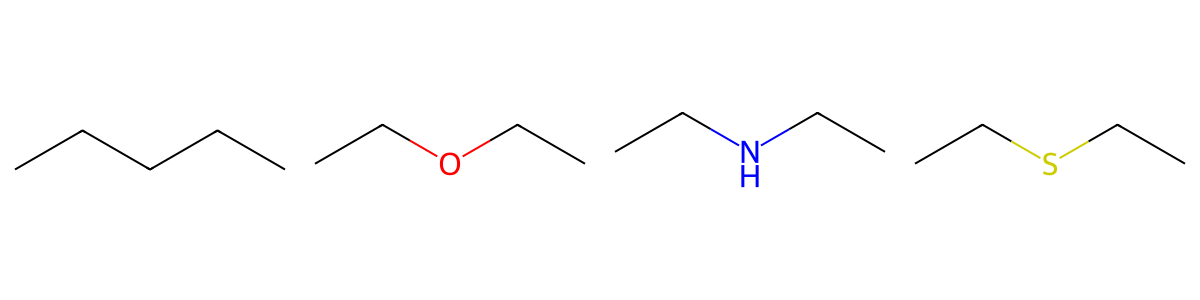

In [14]:
from rdkit.Chem.Draw import MolsToGridImage
smiles_for_smart = ["CCCCC", "CCOCC", "CCNCC", "CCSCC"]
mols_for_smart = [Chem.MolFromSmiles(s) for s in smiles_for_smart]
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300))

In [15]:
query = Chem.MolFromSmarts("CCC")
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (), (), ()]

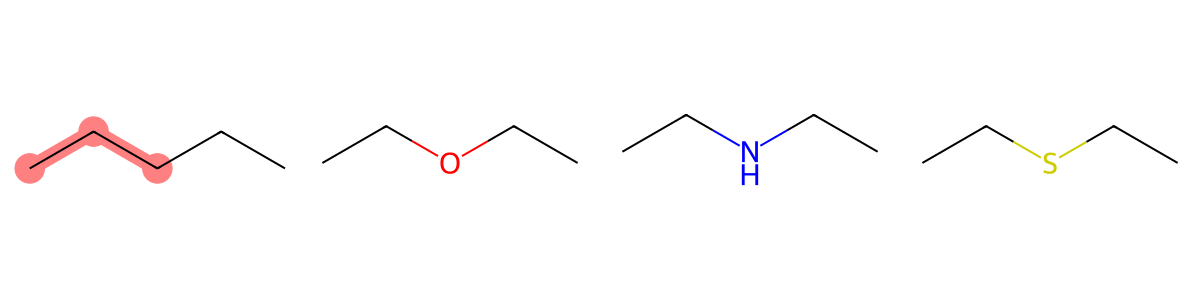

In [16]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)

In [17]:
query = Chem.MolFromSmarts("C[C,N,O]C") # 2개의 탄소 원자 사이에 탄소 or 산소 or 질소 원자 하나가 결합해 있음
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (1, 2, 3), (1, 2, 3), ()]

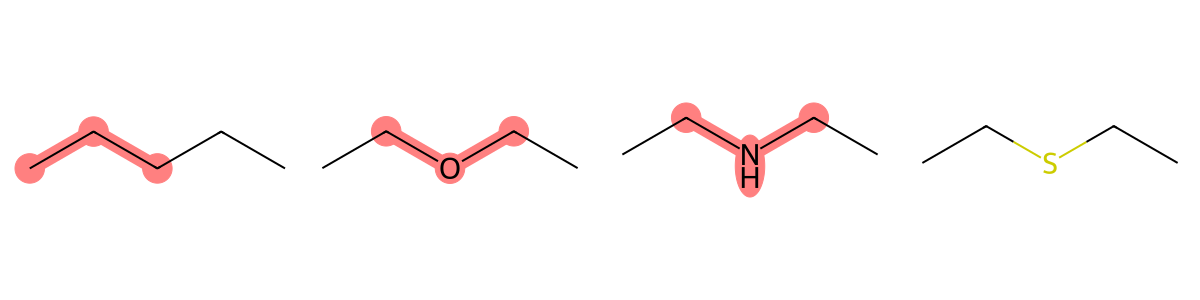

In [18]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)

### 확인 문제
- wildcard (*)를 사용해서 "?"에 들어갈 문자열을 작성하세요

In [22]:
wildcard_text = "C[C,N,O]C" # SMARTS 문자열: C원자 - (C 또는 N 또는 O) 원자 - C원자 구조를 의미합니다.
query = Chem.MolFromSmarts(wildcard_text)
# mols_for_smart는 분자 객체들의 리스트라고 가정
# 각 분자(mole)에서 SMARTS 패턴(query)에 해당하는 부분 구조를 검색
# 해당 부분 구조가 있으면 그 일치하는 원자들의 인덱스를 튜플로 반환
# 없으면 빈 튜플()을 반환
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (1, 2, 3), (1, 2, 3), ()]

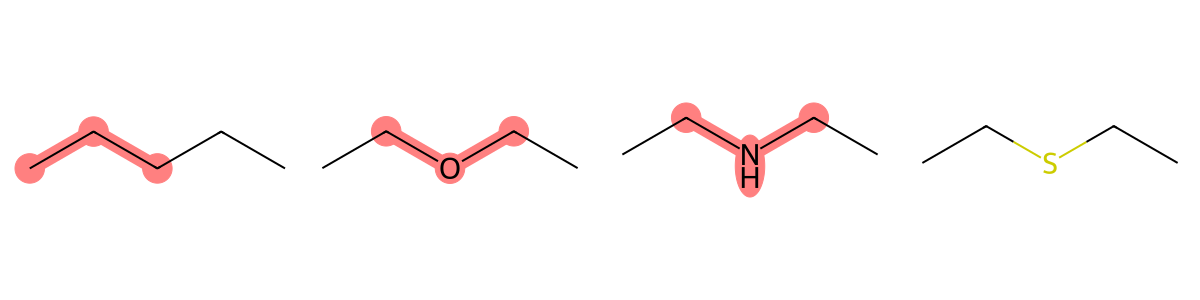

In [23]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)